# Advanced Lane Finding Project
The goals / steps of this project are the following:
- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## First, I'll compute the camera calibration using chessboard images

In [22]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        # img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

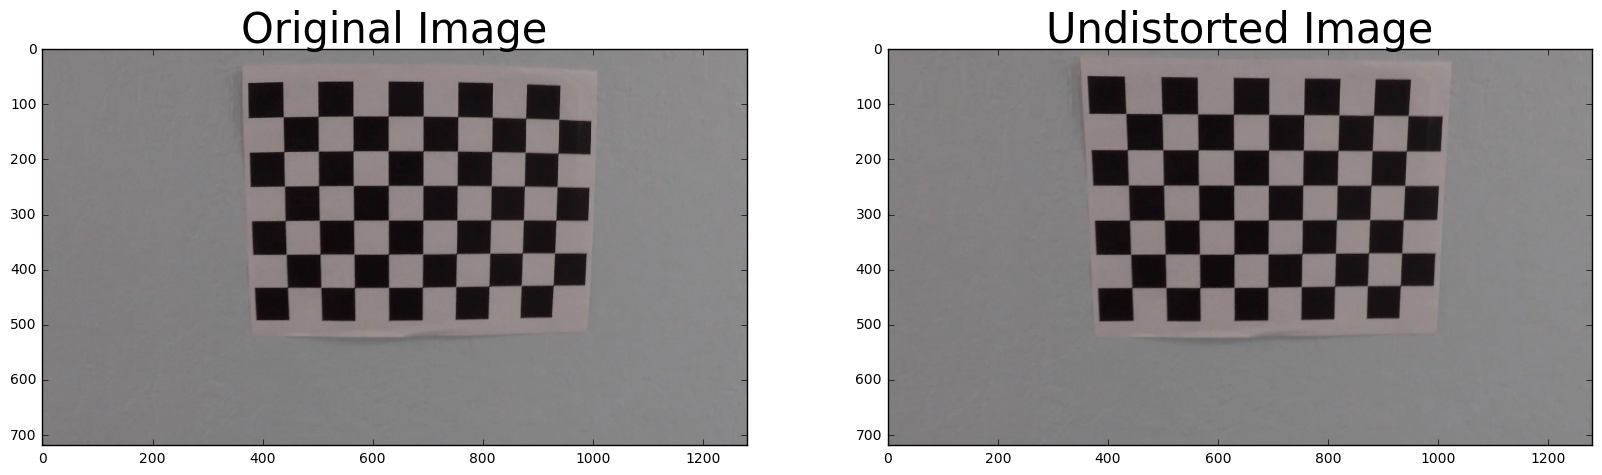

In [4]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration18.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_calibration18.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "output_images/dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

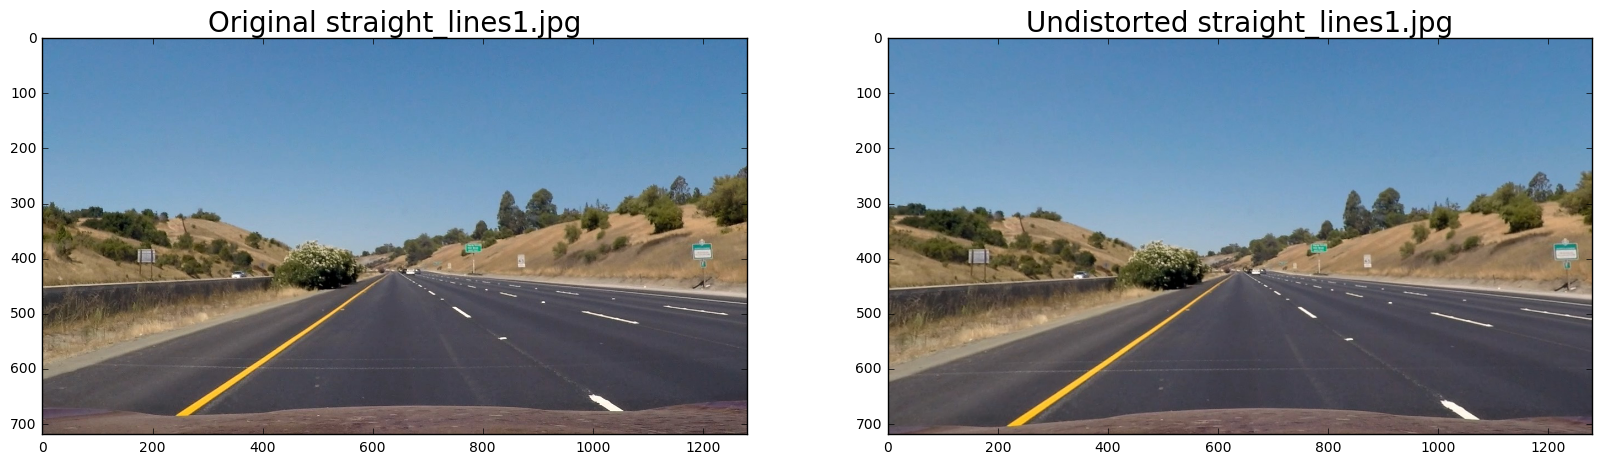

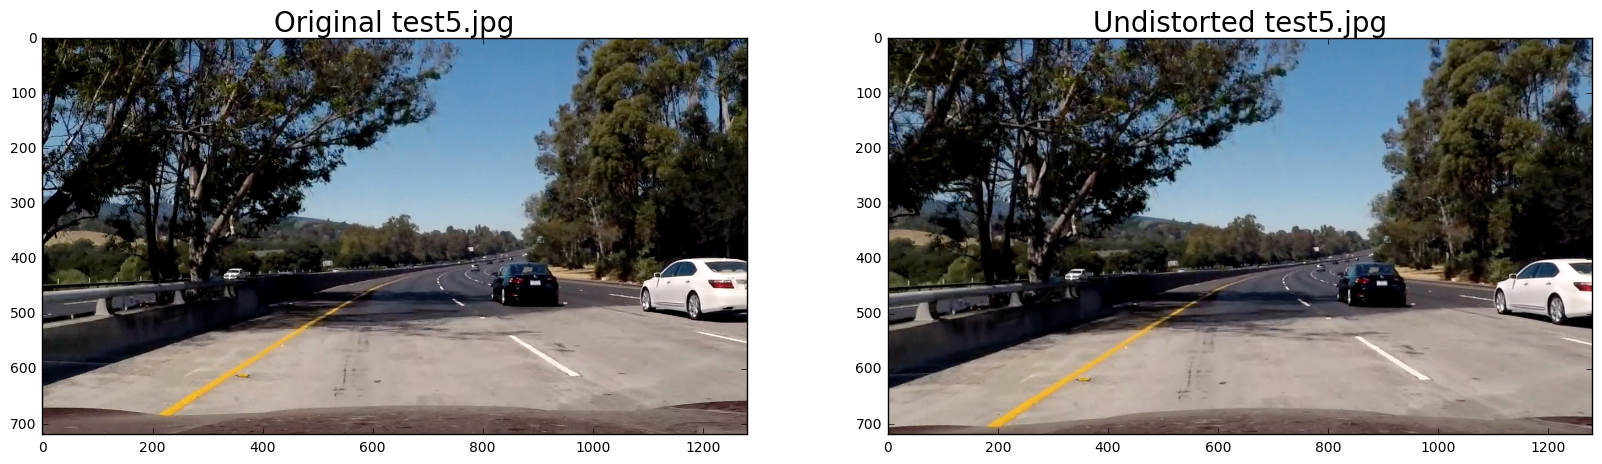

In [23]:
# Test undistortion on a lane image
img_str8 = cv2.imread('test_images/straight_lines1.jpg')
img_test5 = cv2.imread('test_images/test5.jpg')

distortion = pickle.load(open( "output_images/dist_pickle.p", "rb" ) )

img_str8_undistorted = cv2.undistort(img_str8, distortion["mtx"], distortion["dist"], None, distortion["mtx"])
img_test5_undistorted = cv2.undistort(img_test5, distortion["mtx"], distortion["dist"], None, distortion["mtx"])

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
img_str8 = cv2.cvtColor(img_str8, cv2.COLOR_BGR2RGB) # OpenCV imread is BGR, matplotlib is RGB
ax1.imshow(img_str8)
ax1.set_title('Original straight_lines1.jpg', fontsize=20)
img_str8_undistorted = cv2.cvtColor(img_str8_undistorted, cv2.COLOR_BGR2RGB)
ax2.imshow(img_str8_undistorted)
ax2.set_title('Undistorted straight_lines1.jpg', fontsize=20)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
img_test5 = cv2.cvtColor(img_test5, cv2.COLOR_BGR2RGB) # OpenCV imread is BGR, matplotlib is RGB
ax1.imshow(img_test5)
ax1.set_title('Original test5.jpg', fontsize=20)
img_test5_undistorted = cv2.cvtColor(img_test5_undistorted, cv2.COLOR_BGR2RGB)
ax2.imshow(img_test5_undistorted)
ax2.set_title('Undistorted test5.jpg', fontsize=20)

In [24]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_CUBIC)  # keep same size as input image

    return warped

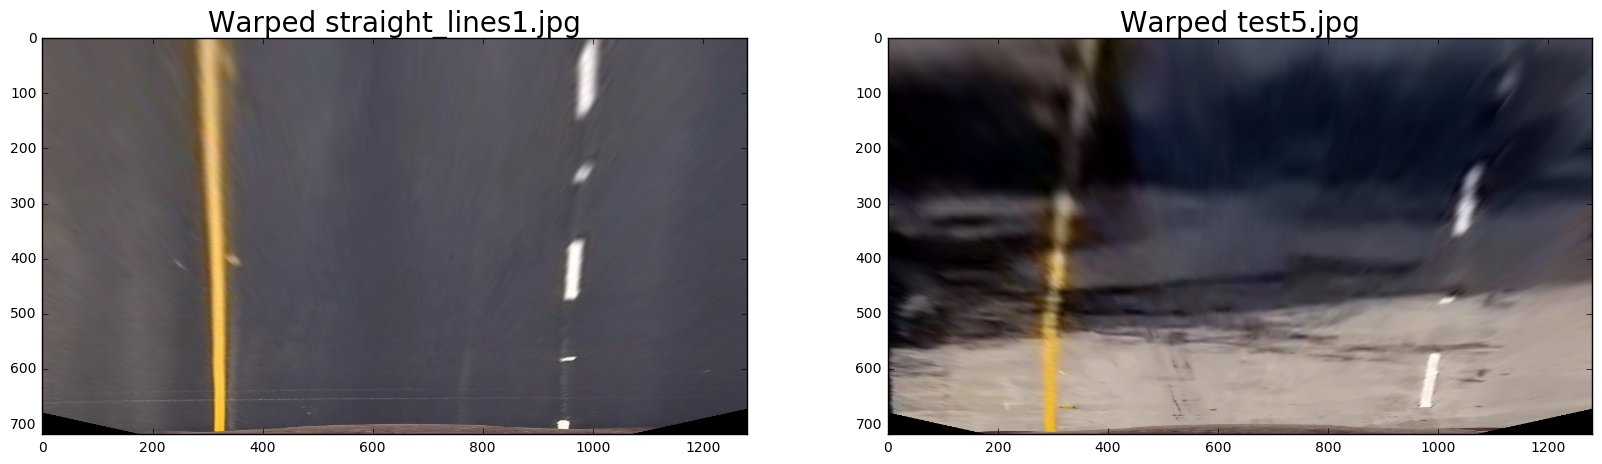

In [25]:
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

img_str8_warped = warper(img_str8_undistorted, src, dst)
img_test5_warped = warper(img_test5_undistorted, src, dst)

# Visualize warping
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_str8_warped)
ax1.set_title('Warped straight_lines1.jpg', fontsize=20)
ax2.imshow(img_test5_warped)
ax2.set_title('Warped test5.jpg', fontsize=20)

## The next step is to prepare the image images before edge detection, focusing on yellow and white lines

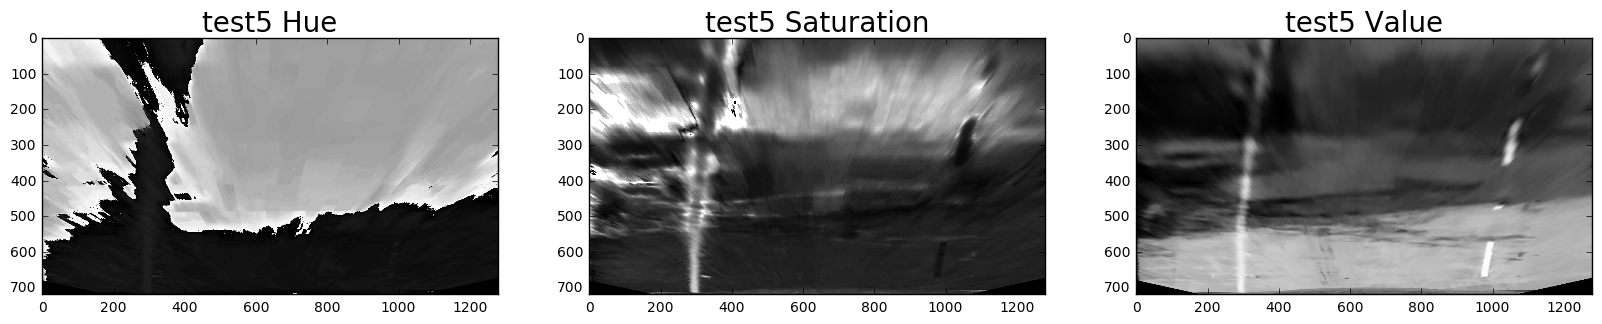

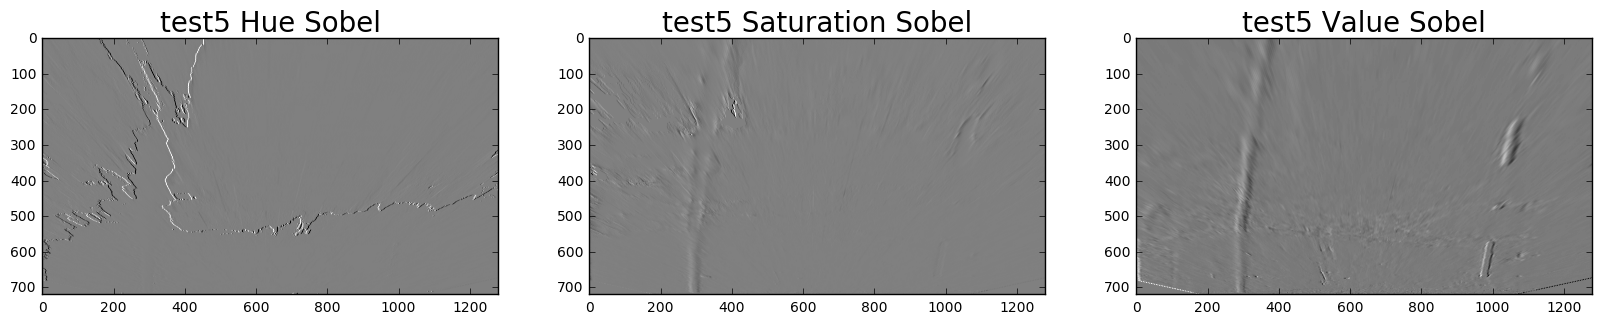

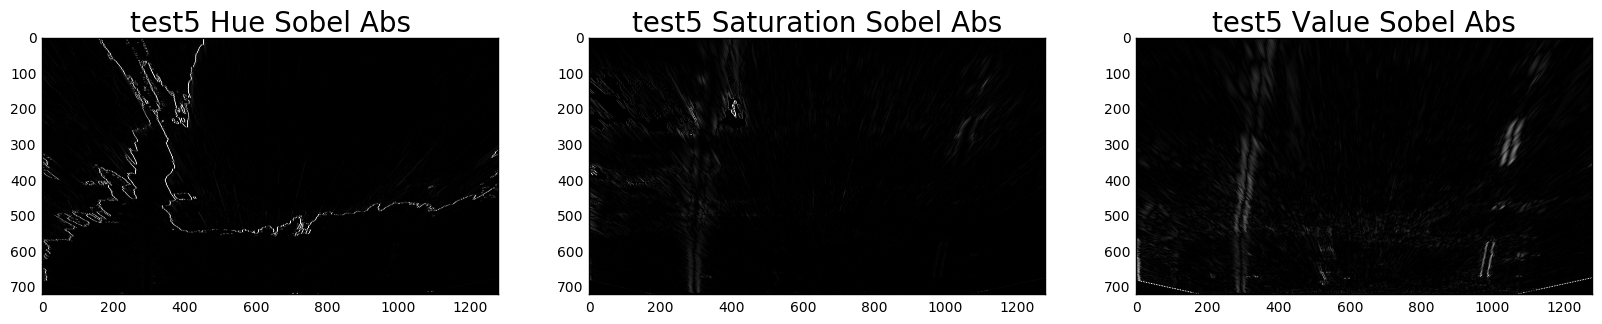

In [50]:
# test a few images first
test5_HSV_img = cv2.cvtColor(img_test5_warped, cv2.COLOR_RGB2HSV).astype(np.float)

# Visualize HSV
f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,10))
ax0.imshow(test5_HSV_img[:,:,0], cmap='gray')
ax0.set_title('test5 Hue', fontsize=20)
ax1.imshow(test5_HSV_img[:,:,1], cmap='gray')
ax1.set_title('test5 Saturation', fontsize=20)
ax2.imshow(test5_HSV_img[:,:,2], cmap='gray')
ax2.set_title('test5 Value', fontsize=20)

# Threshold each channel
#test5_S_img_binary = np.zeros_like(test5_HSV_img[:,:,1])
#test5_S_img_binary[(test5_HSV_img[:,:,1] >= 120) & (test5_HSV_img[:,:,1] <= 200)] = 1
#test5_V_img_binary = np.zeros_like(test5_HSV_img[:,:,2])
#test5_V_img_binary[(test5_HSV_img[:,:,2] >= 80) & (test5_HSV_img[:,:,2] <= 230)] = 1


test5_H_sobelx = cv2.Sobel(test5_HSV_img[:,:,0], cv2.CV_64F, 1, 0, ksize = 5)
abs_test5_H_sobelx = np.absolute(test5_H_sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_test5_H_sobelx = np.uint8(255*abs_test5_H_sobelx/np.max(abs_test5_H_sobelx))
test5_S_sobelx = cv2.Sobel(test5_HSV_img[:,:,1], cv2.CV_64F, 1, 0, ksize = 5)
abs_test5_S_sobelx = np.absolute(test5_S_sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_test5_S_sobelx = np.uint8(255*abs_test5_S_sobelx/np.max(abs_test5_S_sobelx))
test5_V_sobelx = cv2.Sobel(test5_HSV_img[:,:,2], cv2.CV_64F, 1, 0, ksize = 5)
abs_test5_V_sobelx = np.absolute(test5_V_sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_test5_V_sobelx = np.uint8(255*abs_test5_V_sobelx/np.max(abs_test5_V_sobelx))

f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (20,10))
ax0.imshow(test5_H_sobelx, cmap='gray')
ax0.set_title('test5 Hue Sobel', fontsize = 20)
ax1.imshow(test5_S_sobelx, cmap='gray')
ax1.set_title('test5 Saturation Sobel', fontsize = 20)
ax2.imshow(test5_V_sobelx, cmap='gray')
ax2.set_title('test5 Value Sobel', fontsize = 20)

f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (20,10))
ax0.imshow(scaled_test5_H_sobelx, cmap='gray')
ax0.set_title('test5 Hue Sobel Abs', fontsize = 20)
ax1.imshow(scaled_test5_S_sobelx, cmap='gray')
ax1.set_title('test5 Saturation Sobel Abs', fontsize = 20)
ax2.imshow(scaled_test5_V_sobelx, cmap='gray')
ax2.set_title('test5 Value Sobel Abs', fontsize = 20)

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#image = mpimg.imread('bridge_shadow.jpg')

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 249), sx_thresh=(31, 148)):
    img = np.copy(img)
    # Convert to HLS color space and separate the L, S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # return combination
    s_or_sx = np.zeros_like(sxbinary)
    s_or_sx[(s_binary == 1) | (sxbinary == 1)] = 1
    return s_or_sx
    
img_str8_warped_binary = pipeline(img_str8_warped)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img_str8_warped)
ax1.set_title('straight_lines1.jpg warped', fontsize = 20)
ax2.imshow(img_str8_warped_binary, cmap='gray')
ax2.set_title('straight_lines1.jpg after gradient thresholding', fontsize = 20)
#ax3.imshow(cv2.calcHist([img_str8_warped_binary],[0],None,[256],[0,256]))
ax3.hist(np.sum(img_str8_warped_binary,axis=0))
ax3.set_title('straight_lines1.jpg histogram', fontsize = 20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
img_test5_warped_binary = pipeline(img_test5_warped)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img_test5_warped)
ax1.set_title('test5.jpg warped', fontsize = 20)
ax2.imshow(img_test5_warped_binary, cmap='gray')
ax2.set_title('test5.jpg after gradient thresholding', fontsize = 20)
#ax3.imshow(cv2.calcHist([img_test5_warped_binary],[0],None,[256],[0,256]))
ax3.hist(np.sum(img_test5_warped_binary,axis=0))

ax3.set_title('test5.jpg histogram', fontsize = 20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)